# **Detección de Defectos en Manufactura**
*María Camila García Ramírez*

# **Código**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pandas as pd
import shutil
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import cv2
from matplotlib import pyplot as plt
from scipy.stats import skew, kurtosis
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

**Carga y preprocesamiento**

In [ ]:
import os

# Ajusta esta ruta según donde esté tu carpeta del proyecto en tu Drive
BASE_DIR = '/content/drive/MyDrive/Severstal'

TRAIN_CSV_PATH = os.path.join(BASE_DIR, 'train.csv')
TRAIN_IMAGES_DIR = os.path.join(BASE_DIR, 'train_images')


In [ ]:
BASE_DIR = '/content/drive/MyDrive/Vision_computadora/Taller_2'
IMAGES_DIR = os.path.join(BASE_DIR, 'train_images')
OUT_DIR = os.path.join(BASE_DIR, 'train_images_filtradas')
CSV_PATH = os.path.join(BASE_DIR, 'train.csv')

os.makedirs(OUT_DIR, exist_ok=True)

df = pd.read_csv(CSV_PATH)
df = df[df["EncodedPixels"].notnull()]
image_ids = df["ImageId"].unique()[:200]

for img in image_ids:
    src = os.path.join(IMAGES_DIR, img)
    dst = os.path.join(OUT_DIR, img)
    if os.path.exists(src):
        shutil.copy(src, dst)

print(f"✅ Se copiaron {len(image_ids)} imágenes con defectos a {OUT_DIR}")

✅ Se copiaron 200 imágenes con defectos a /content/drive/MyDrive/Vision_computadora/Taller_2/train_images_filtradas


**Imágenes y máscara**

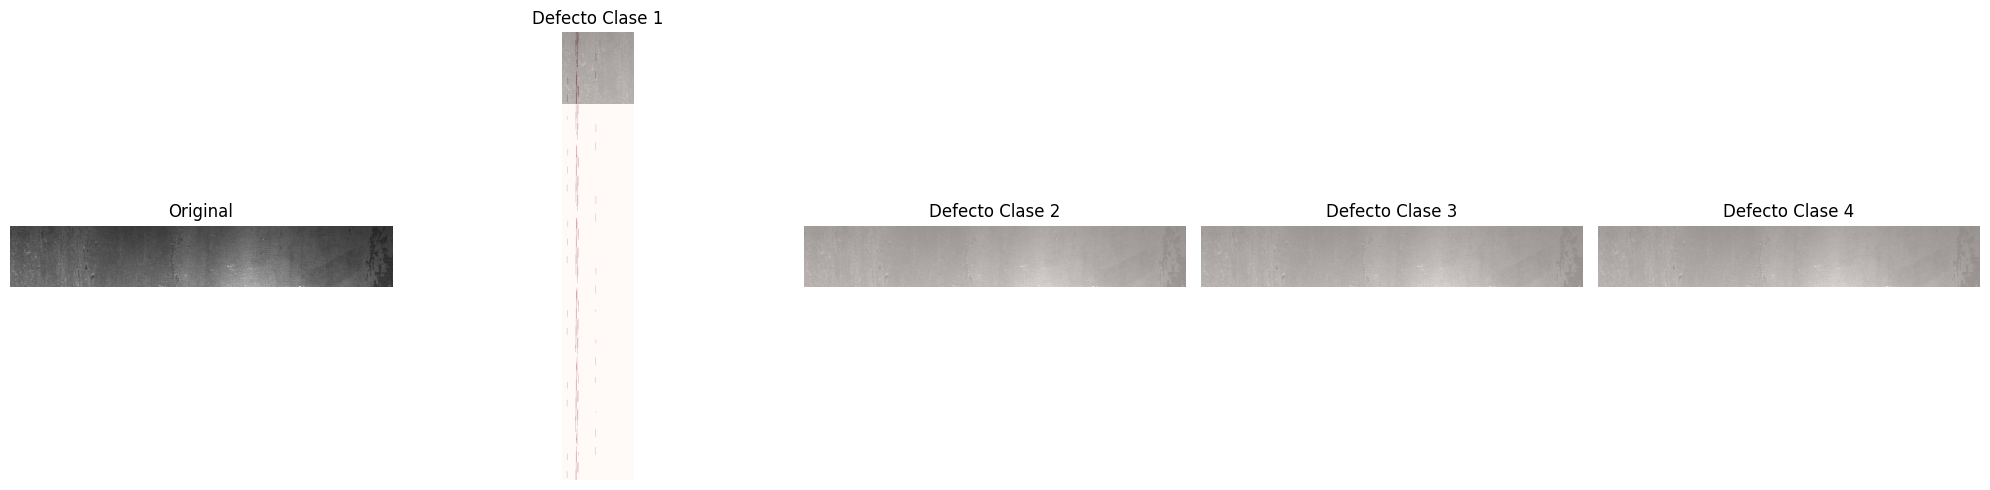

In [ ]:
# Dimensiones fijas del dataset Severstal
IMG_WIDTH = 1600
IMG_HEIGHT = 256

# Función para convertir RLE a máscara binaria
def rle_decode(mask_rle, shape=(IMG_HEIGHT, IMG_WIDTH)):
    if pd.isna(mask_rle):
        return np.zeros(shape, dtype=np.uint8)

    s = mask_rle.strip().split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0::2], s[1::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)

    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1

    return img.reshape(shape).T  # Transponer para que coincida con la imagen

# Función para mostrar imagen + máscara
def show_image_with_masks(image_id, df, image_dir):
    img_path = os.path.join(image_dir, image_id)
    img = np.array(Image.open(img_path).convert('RGB'))

    fig, axs = plt.subplots(1, 5, figsize=(20, 5))
    axs[0].imshow(img)
    axs[0].set_title("Original")
    axs[0].axis("off")

    for i in range(1, 5):
        mask_data = df[(df['ImageId'] == image_id) & (df['ClassId'] == i)]
        if not mask_data.empty:
            mask = rle_decode(mask_data['EncodedPixels'].values[0])
        else:
            mask = np.zeros((IMG_HEIGHT, IMG_WIDTH), dtype=np.uint8)

        axs[i].imshow(img)
        axs[i].imshow(mask, alpha=0.5, cmap='Reds')
        axs[i].set_title(f"Defecto Clase {i}")
        axs[i].axis("off")

    plt.tight_layout()
    plt.show()

ejemplo_img = image_ids[0]
mostrar_imagen_con_mascaras(ejemplo_img, df, OUT_DIR)

**Preprocesamiento**

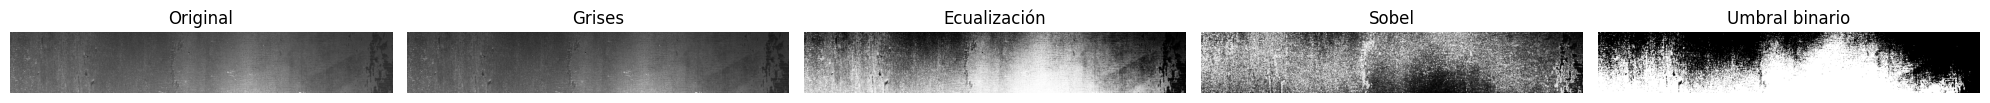

In [ ]:
# Función de preprocesamiento completo
def preprocesar_imagen(img):
    # 1. Escala de grises
    gris = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # 2. Ecualización de histograma
    ecualizada = cv2.equalizeHist(gris)

    # 3. Filtro Sobel (bordes)
    sobelx = cv2.Sobel(ecualizada, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(ecualizada, cv2.CV_64F, 0, 1, ksize=3)
    sobel = cv2.magnitude(sobelx, sobely)
    sobel = np.uint8(np.clip(sobel, 0, 255))

    # 4. Umbralización (binaria con Otsu)
    _, umbral = cv2.threshold(ecualizada, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    return gris, ecualizada, sobel, umbral

# Visualización del flujo de preprocesamiento
def visualizar_preprocesamiento(image_id, image_dir):
    img_path = os.path.join(image_dir, image_id)
    img = np.array(Image.open(img_path).convert('RGB'))

    gris, ecualizada, sobel, umbral = preprocesar_imagen(img)

    fig, axs = plt.subplots(1, 5, figsize=(20, 5))
    axs[0].imshow(img)
    axs[0].set_title("Original")
    axs[0].axis("off")

    axs[1].imshow(gris, cmap='gray')
    axs[1].set_title("Grises")
    axs[1].axis("off")

    axs[2].imshow(ecualizada, cmap='gray')
    axs[2].set_title("Ecualización")
    axs[2].axis("off")

    axs[3].imshow(sobel, cmap='gray')
    axs[3].set_title("Sobel")
    axs[3].axis("off")

    axs[4].imshow(umbral, cmap='gray')
    axs[4].set_title("Umbral binario")
    axs[4].axis("off")

    plt.tight_layout()
    plt.show()

visualizar_preprocesamiento(ejemplo_img, OUT_DIR)

**Extracción de características**

In [ ]:
def extraer_caracteristicas(imagen_gris, imagen_umbral):
    # 1. Histograma (256 bins)
    hist = cv2.calcHist([imagen_gris], [0], None, [256], [0, 256]).flatten()

    # 2. Estadísticos del histograma
    media = np.mean(imagen_gris)
    std = np.std(imagen_gris)
    skewness = skew(imagen_gris.flatten())
    curtosis = kurtosis(imagen_gris.flatten())

    # 3. Porcentaje de píxeles blancos (binarios)
    blancos = np.sum(imagen_umbral == 255)
    total = imagen_umbral.size
    porcentaje_blancos = blancos / total

    return {
        'media': media,
        'std': std,
        'skewness': skewness,
        'curtosis': curtosis,
        'porcentaje_blancos': porcentaje_blancos,
        'histograma': hist
    }
# Procesar y extraer características de una imagen
img_path = os.path.join(OUT_DIR, ejemplo_img)
img = np.array(Image.open(img_path).convert('RGB'))
gris, _, _, umbral = preprocesar_imagen(img)

caracteristicas = extraer_caracteristicas(gris, umbral)

# Mostrar características extraídas
for clave, valor in caracteristicas.items():
    if clave != 'histograma':
        print(f"{clave}: {valor:.4f}")

media: 92.5314
std: 24.3942
skewness: 0.7562
curtosis: 1.1589
porcentaje_blancos: 0.5081


**Dataset de características para todas las imágenes con defecto**

In [ ]:
IMG_DIR = '/content/drive/MyDrive/Vision_computadora/Taller_2/train_images'

train = pd.read_csv('/content/drive/MyDrive/Vision_computadora/Taller_2/train.csv')
train.head()

ids_con_defecto = train[train['EncodedPixels'].notnull()]['ImageId'].unique()

# Lista para almacenar características
caracteristicas_todas = []

# Procesar imágenes
for img_id in tqdm(ids_con_defecto[:500]):
    try:
        img_path = os.path.join(IMG_DIR, img_id)
        img = np.array(Image.open(img_path).convert('RGB'))

        # Funciones que ya debes tener definidas
        gris, _, _, umbral = preprocesar_imagen(img)
        caracteristicas = extraer_caracteristicas(gris, umbral)

        # Añadir ID y clase
        clases = train[train['ImageId'] == img_id]['ClassId'].unique()
        for clase in clases:
            fila = {
                'ImageId': img_id,
                'ClassId': clase,
                'media': caracteristicas['media'],
                'std': caracteristicas['std'],
                'skewness': caracteristicas['skewness'],
                'curtosis': caracteristicas['curtosis'],
                'porcentaje_blancos': caracteristicas['porcentaje_blancos'],
            }
            caracteristicas_todas.append(fila)

    except Exception as e:
        print(f"Error con {img_id}: {e}")

# Crear DataFrame final
df_features = pd.DataFrame(caracteristicas_todas)
df_features.head()

100%|██████████| 500/500 [01:59<00:00,  4.17it/s]


,ImageId,ClassId,media,std,skewness,curtosis,porcentaje_blancos
0,0002cc93b.jpg,1,92.531357,24.394154,0.756190,1.158899,0.508105
1,0007a71bf.jpg,3,96.409568,23.442527,0.810062,1.116263,0.513799
2,000a4bcdd.jpg,1,77.291123,16.822945,0.684077,1.154461,0.493137
3,000f6bf48.jpg,4,87.792788,28.440930,0.663174,0.157954,0.497224
4,0014fce06.jpg,3,52.267988,46.581197,0.296158,-0.675605,0.447773


**Random Forest**

Reporte de clasificación:
              precision    recall  f1-score   support

           1       0.55      0.43      0.48        14
           2       0.50      0.40      0.44         5
           3       0.79      0.90      0.84        77
           4       0.25      0.10      0.14        10

    accuracy                           0.74       106
   macro avg       0.52      0.46      0.48       106
weighted avg       0.70      0.74      0.71       106



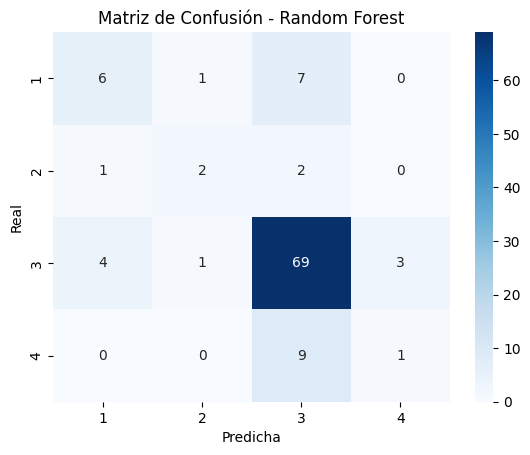

In [ ]:
# Variables predictoras (X) y variable objetivo (y)
X = df_features[['media', 'std', 'skewness', 'curtosis', 'porcentaje_blancos']]
y = df_features['ClassId']

# Separar en entrenamiento y prueba (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Modelo Random Forest
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predicciones
y_pred = clf.predict(X_test)

# Reporte de métricas
print("Reporte de clasificación:")
print(classification_report(y_test, y_pred))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[1,2,3,4], yticklabels=[1,2,3,4])
plt.xlabel('Predicha')
plt.ylabel('Real')
plt.title('Matriz de Confusión - Random Forest')
plt.show()

**SVM (Support Vector Machine)**

Clasificación con SVM
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        14
           2       0.00      0.00      0.00         5
           3       0.73      1.00      0.84        77
           4       0.00      0.00      0.00        10

    accuracy                           0.73       106
   macro avg       0.18      0.25      0.21       106
weighted avg       0.53      0.73      0.61       106



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


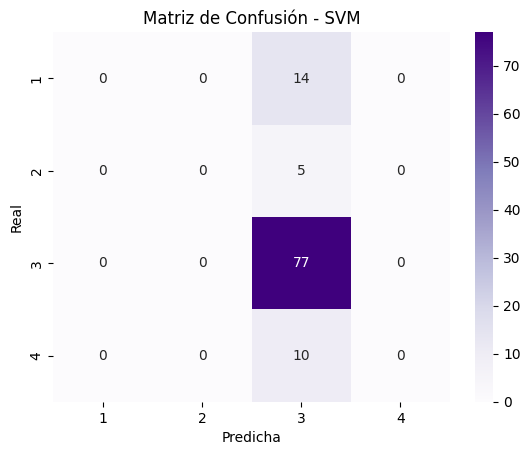

In [ ]:
svm_model = SVC(kernel='rbf', C=1, gamma='scale', random_state=42)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

print("Clasificación con SVM")
print(classification_report(y_test, y_pred_svm))

cm_svm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Purples', xticklabels=[1,2,3,4], yticklabels=[1,2,3,4])
plt.title("Matriz de Confusión - SVM")
plt.xlabel("Predicha")
plt.ylabel("Real")
plt.show()

**K-Nearest Neighbors (kNN)**

Clasificación con kNN
              precision    recall  f1-score   support

           1       0.36      0.36      0.36        14
           2       0.17      0.20      0.18         5
           3       0.76      0.83      0.80        77
           4       0.00      0.00      0.00        10

    accuracy                           0.66       106
   macro avg       0.32      0.35      0.33       106
weighted avg       0.61      0.66      0.63       106



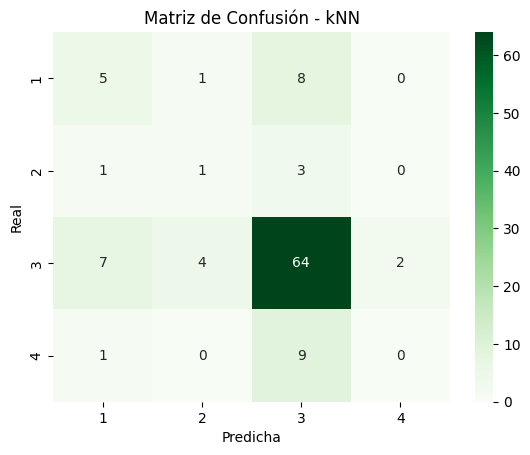

In [ ]:
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)

print("Clasificación con kNN")
print(classification_report(y_test, y_pred_knn))

cm_knn = confusion_matrix(y_test, y_pred_knn)
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Greens', xticklabels=[1,2,3,4], yticklabels=[1,2,3,4])
plt.title("Matriz de Confusión - kNN")
plt.xlabel("Predicha")
plt.ylabel("Real")
plt.show()

**Naive Bayes (extra)**

Clasificación con Naive Bayes
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        14
           2       0.20      0.40      0.27         5
           3       0.74      0.32      0.45        77
           4       0.15      0.90      0.25        10

    accuracy                           0.34       106
   macro avg       0.27      0.41      0.24       106
weighted avg       0.56      0.34      0.36       106



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


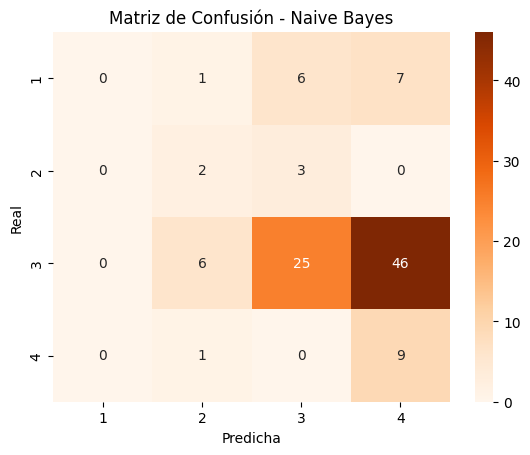

In [ ]:
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)

print("Clasificación con Naive Bayes")
print(classification_report(y_test, y_pred_nb))

cm_nb = confusion_matrix(y_test, y_pred_nb)
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Oranges', xticklabels=[1,2,3,4], yticklabels=[1,2,3,4])
plt.title("Matriz de Confusión - Naive Bayes")
plt.xlabel("Predicha")
plt.ylabel("Real")
plt.show()

**Comparación de precisión entre modelos**

<ipython-input-22-0c1dab671827>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(modelos.keys()), y=list(modelos.values()), palette='Set2')


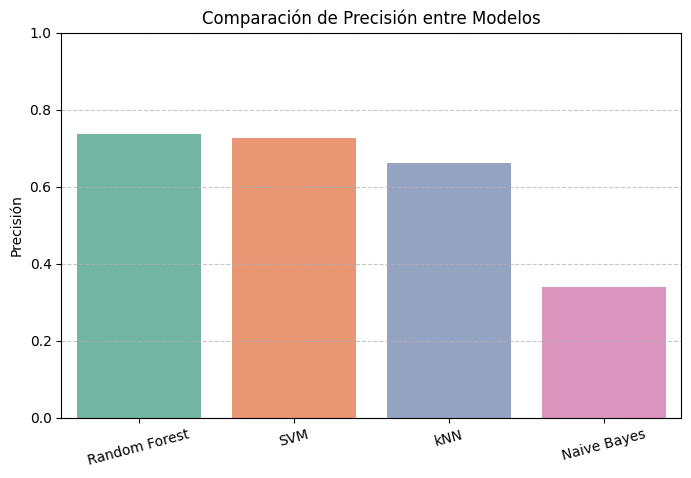

In [ ]:
# Cálculo de precisión
accuracy_rf = accuracy_score(y_test, y_pred)               # Random Forest
accuracy_svm = accuracy_score(y_test, y_pred_svm)          # SVM
accuracy_knn = accuracy_score(y_test, y_pred_knn)          # kNN
accuracy_nb = accuracy_score(y_test, y_pred_nb)            # Naive Bayes

# Diccionario con resultados
modelos = {
    'Random Forest': accuracy_rf,
    'SVM': accuracy_svm,
    'kNN': accuracy_knn,
    'Naive Bayes': accuracy_nb
}

# Gráfica
plt.figure(figsize=(8,5))
sns.barplot(x=list(modelos.keys()), y=list(modelos.values()), palette='Set2')
plt.ylim(0,1)
plt.ylabel('Precisión')
plt.title('Comparación de Precisión entre Modelos')
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()